### Deep Reinforcement Learning for 4X4 Mini Chess Variants ###

AlphaZero-like MCTS for 4x4 Mini Chess Variants

Author: Sanghun Han

In my implementation, I referenced the AlphaZero method as discussed in the following paper:

**Hongming Zhang and Tianyang Yu**, *AlphaZero* DOI: [https://doi.org/10.1007/978-981-15-4095-0_15](https://doi.org/10.1007/978-981-15-4095-0_15)

In [1]:
import subprocess
import sys

# Check and install numpy if not installed
try:
    import numpy as np
except ImportError:
    print("numpy not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
    import numpy as np

# Check and install torch if not installed
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
except ImportError:
    print("torch not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim

# Check and install matplotlib if not installed
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("matplotlib not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt

# Other imports
import math
import time
import random
import os
import ast  # For safely evaluating strings to lists

In [2]:
# Configuration settings for 4x4 Minichess
MCTS_SIMULATIONS = 800
NUM_RES_BLOCKS = 10
BATCH_SIZE = 384
LEARNING_RATE = 0.01  # Initial learning rate
MOMENTUM = 0.05
ACTION_SIZE = 384  # Consistent with the action space defined in build_action_space

BOARD_SIZE = 4  # 4x4 board
TOTAL_SQUARES = BOARD_SIZE * BOARD_SIZE  # 16 squares

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Define piece codes
# White pieces: 1-6
# Black pieces: 7-12
PIECE_CODES = {
    'empty': 0,
    'w_pawn': 1,
    'w_rook': 2,
    'w_knight': 3,
    'w_bishop': 4,
    'w_queen': 5,
    'w_king': 6,
    'b_pawn': 7,
    'b_rook': 8,
    'b_knight': 9,
    'b_bishop': 10,
    'b_queen': 11,
    'b_king': 12,
}

# Direction vectors for piece movements
DIRECTIONS = {
    'rook': [(-1, 0), (1, 0), (0, -1), (0, 1)],
    'bishop': [(-1, -1), (-1, 1), (1, -1), (1, 1)],
    'queen': [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)],
    'knight': [(-2, -1), (-2, 1), (-1, -2), (-1, 2),
               (1, -2), (1, 2), (2, -1), (2, 1)],
    'king': [(-1, -1), (-1, 0), (-1, 1),
             (0, -1),          (0, 1),
             (1, -1),  (1, 0), (1, 1)],
}

# Mapping from piece code to piece type
PIECE_TYPE = {
    1: 'pawn',
    2: 'rook',
    3: 'knight',
    4: 'bishop',
    5: 'queen',
    6: 'king',
    7: 'pawn',
    8: 'rook',
    9: 'knight',
    10: 'bishop',
    11: 'queen',
    12: 'king',
}

In [3]:
# Build action space
def build_action_space():
    action_space = {}
    index = 0
    for from_sq in range(TOTAL_SQUARES):
        for to_sq in range(TOTAL_SQUARES):
            action_space[(from_sq, to_sq, 0)] = index
            index += 1
            # Add promotion actions
            from_rank = from_sq // BOARD_SIZE
            to_rank = to_sq // BOARD_SIZE
            if from_rank == 1 and to_rank == 0:
                # White pawn promotion
                for promo_piece in [PIECE_CODES['w_queen'], PIECE_CODES['w_rook'],
                                    PIECE_CODES['w_bishop'], PIECE_CODES['w_knight']]:
                    action_space[(from_sq, to_sq, promo_piece)] = index
                    index += 1
            elif from_rank == 2 and to_rank == 3:
                # Black pawn promotion
                for promo_piece in [PIECE_CODES['b_queen'], PIECE_CODES['b_rook'],
                                    PIECE_CODES['b_bishop'], PIECE_CODES['b_knight']]:
                    action_space[(from_sq, to_sq, promo_piece)] = index
                    index += 1
    #print(f"Action space size: {len(action_space)}")
    return action_space

# Initialize action space
ACTION_SPACE = build_action_space()
ACTION_SIZE = len(ACTION_SPACE)

# Game logic functions
def get_initial_state():
    """
    Returns the initial game state as per the specified position representation.
    """
    # Index 0-15 represent the squares, index 16 is the player to move (1 for White)
    # Starting position:
    pos = [10, 12, 10, 11, 7, 7, 7, 7, 1, 1, 1, 1, 6, 4, 3, 5, 1]
    return pos

def encode_board(pos):
    """
    Encodes the board position into a 12x4x4 tensor.
    Each channel corresponds to a piece type.
    """
    board_tensor = np.zeros((12, BOARD_SIZE, BOARD_SIZE), dtype=np.float32)  # 12 piece types
    for idx in range(TOTAL_SQUARES):
        piece = pos[idx]
        if piece != 0:
            piece_idx = piece - 1  # Adjusting for 0-based indexing
            row = idx // BOARD_SIZE
            col = idx % BOARD_SIZE
            board_tensor[piece_idx, row, col] = 1.0
    return board_tensor

def apply_action(pos, action):
    """
    Applies the action to the position and returns the new position.
    Action is a tuple (from_sq, to_sq, promotion_piece).
    """
    from_sq, to_sq, promotion_piece = action
    new_pos = pos.copy()

    moving_piece = new_pos[from_sq]
    # Move the piece
    new_pos[to_sq] = moving_piece
    new_pos[from_sq] = 0

    # Handle promotion
    if promotion_piece != 0:
        new_pos[to_sq] = promotion_piece

    # Switch player turn
    new_pos[16] = 2 if new_pos[16] == 1 else 1

    return new_pos

def get_piece_positions(pos, player_pieces):
    """
    Returns a list of tuples (piece_code, position_index) for all pieces belonging to the player.
    """
    pieces = []
    for idx in range(TOTAL_SQUARES):
        piece = pos[idx]
        if piece in player_pieces:
            pieces.append((piece, idx))
    return pieces

def generate_sliding_moves(pos, piece_code, position_idx, directions):
    """
    Generates moves for sliding pieces (rook, bishop, queen).
    """
    moves = []
    player = 1 if piece_code <= 6 else 2
    opponent_pieces = range(7, 13) if player == 1 else range(1, 7)

    row = position_idx // BOARD_SIZE
    col = position_idx % BOARD_SIZE

    for dr, dc in directions:
        r, c = row + dr, col + dc
        while 0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE:
            idx = r * BOARD_SIZE + c
            target_piece = pos[idx]
            if target_piece == 0:
                moves.append((position_idx, idx, 0))
            elif target_piece in opponent_pieces:
                moves.append((position_idx, idx, 0))
                break
            else:
                break
            r += dr
            c += dc

    return moves

def generate_pawn_moves(pos, piece_code, position_idx):
    """
    Generates moves for pawns, including promotions.
    """
    moves = []
    player = 1 if piece_code <= 6 else 2
    opponent_pieces = range(7, 13) if player == 1 else range(1, 7)
    direction = -1 if player == 1 else 1

    row = position_idx // BOARD_SIZE
    col = position_idx % BOARD_SIZE

    # Forward move
    r, c = row + direction, col
    if 0 <= r < BOARD_SIZE:
        idx = r * BOARD_SIZE + c
        if pos[idx] == 0:
            # Promotion
            if (player == 1 and r == 0) or (player == 2 and r == BOARD_SIZE - 1):
                promo_pieces = [PIECE_CODES['w_queen'], PIECE_CODES['w_rook'],
                                PIECE_CODES['w_bishop'], PIECE_CODES['w_knight']] if player == 1 else \
                               [PIECE_CODES['b_queen'], PIECE_CODES['b_rook'],
                                PIECE_CODES['b_bishop'], PIECE_CODES['b_knight']]
                for promo_piece in promo_pieces:
                    moves.append((position_idx, idx, promo_piece))
            else:
                moves.append((position_idx, idx, 0))

    # Captures
    for dc in [-1, 1]:
        r, c = row + direction, col + dc
        if 0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE:
            idx = r * BOARD_SIZE + c
            target_piece = pos[idx]
            if target_piece in opponent_pieces:
                # Promotion
                if (player == 1 and r == 0) or (player == 2 and r == BOARD_SIZE - 1):
                    promo_pieces = [PIECE_CODES['w_queen'], PIECE_CODES['w_rook'],
                                    PIECE_CODES['w_bishop'], PIECE_CODES['w_knight']] if player == 1 else \
                                   [PIECE_CODES['b_queen'], PIECE_CODES['b_rook'],
                                    PIECE_CODES['b_bishop'], PIECE_CODES['b_knight']]
                    for promo_piece in promo_pieces:
                        moves.append((position_idx, idx, promo_piece))
                else:
                    moves.append((position_idx, idx, 0))

    return moves

def generate_knight_moves(pos, piece_code, position_idx):
    """
    Generates moves for knights.
    """
    moves = []
    player = 1 if piece_code <= 6 else 2
    opponent_pieces = range(7, 13) if player == 1 else range(1, 7)

    row = position_idx // BOARD_SIZE
    col = position_idx % BOARD_SIZE

    for dr, dc in DIRECTIONS['knight']:
        r, c = row + dr, col + dc
        if 0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE:
            idx = r * BOARD_SIZE + c
            target_piece = pos[idx]
            if target_piece == 0 or target_piece in opponent_pieces:
                moves.append((position_idx, idx, 0))

    return moves

def generate_king_moves(pos, piece_code, position_idx):
    """
    Generates moves for the king.
    """
    moves = []
    player = 1 if piece_code <= 6 else 2
    opponent_pieces = range(7, 13) if player == 1 else range(1, 7)

    row = position_idx // BOARD_SIZE
    col = position_idx % BOARD_SIZE

    for dr, dc in DIRECTIONS['king']:
        r, c = row + dr, col + dc
        if 0 <= r < BOARD_SIZE and 0 <= c < BOARD_SIZE:
            idx = r * BOARD_SIZE + c
            target_piece = pos[idx]
            if target_piece == 0 or target_piece in opponent_pieces:
                moves.append((position_idx, idx, 0))

    return moves

def legal_moves(pos):
    """
    Generates all possible legal moves for the current player in the given position.
    Returns a dictionary mapping action tuples to new positions.
    """
    current_player = pos[16]
    player_pieces = range(1, 7) if current_player == 1 else range(7, 13)
    legal_actions = {}

    pieces = get_piece_positions(pos, player_pieces)
    all_moves = []

    for piece_code, position_idx in pieces:
        piece_type = PIECE_TYPE[piece_code]
        if piece_type == 'pawn':
            moves = generate_pawn_moves(pos, piece_code, position_idx)
        elif piece_type == 'rook':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['rook'])
        elif piece_type == 'bishop':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['bishop'])
        elif piece_type == 'queen':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['queen'])
        elif piece_type == 'knight':
            moves = generate_knight_moves(pos, piece_code, position_idx)
        elif piece_type == 'king':
            moves = generate_king_moves(pos, piece_code, position_idx)
        else:
            moves = []
        all_moves.extend(moves)

    # Remove moves that leave the player in check
    for action in all_moves:
        new_pos = apply_action(pos, action)
        if not is_check(new_pos, current_player):
            legal_actions[action] = new_pos

    return legal_actions

def is_check(pos, player):
    """
    Returns True if the player's king is in check, False otherwise.
    """
    opponent = 2 if player == 1 else 1
    opponent_pieces = range(7, 13) if opponent == 2 else range(1, 7)
    player_king_code = PIECE_CODES['w_king'] if player == 1 else PIECE_CODES['b_king']

    # Find the king's position
    try:
        king_idx = pos.index(player_king_code)
    except ValueError:
        # King is not on the board (captured)
        return True

    # Generate all possible moves for the opponent
    opponent_moves = []

    pieces = get_piece_positions(pos, opponent_pieces)
    for piece_code, position_idx in pieces:
        piece_type = PIECE_TYPE[piece_code]
        if piece_type == 'pawn':
            moves = generate_pawn_moves(pos, piece_code, position_idx)
        elif piece_type == 'rook':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['rook'])
        elif piece_type == 'bishop':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['bishop'])
        elif piece_type == 'queen':
            moves = generate_sliding_moves(pos, piece_code, position_idx, DIRECTIONS['queen'])
        elif piece_type == 'knight':
            moves = generate_knight_moves(pos, piece_code, position_idx)
        elif piece_type == 'king':
            moves = generate_king_moves(pos, piece_code, position_idx)
        else:
            moves = []
        opponent_moves.extend(moves)

    # Check if any of the opponent's moves can capture the king
    for _, to_idx, _ in opponent_moves:
        if to_idx == king_idx:
            return True

    return False

def get_game_status(pos, move_count=0, position_history=None):
    """
    Determine the status of the game based on the current board position and draw conditions.
    
    Parameters:
    pos (list or tuple): The current position of the game, including player turn at index 16.
    move_count (int): The number of consecutive moves without a pawn move or capture.
    position_history (dict): A dictionary tracking the number of times each position has occurred.
    
    Returns:
    tuple: A tuple indicating whether the game is over, the winner (if any), and the reason.
           - (True, winner, 'checkmate') if there's a checkmate
           - (True, 0, 'stalemate') if there's a stalemate
           - (True, 0, 'fifty-move rule') if the fifty-move rule is triggered
           - (True, 0, 'threefold repetition') if threefold repetition is triggered
           - (True, 0, 'insufficient material') if there’s insufficient material
           - (False, None, None) if the game is ongoing
    """
    current_player = pos[16]
    legal_actions = legal_moves(pos)

    if not legal_actions:
        if is_check(pos, current_player):
            # Checkmate
            winner = 2 if current_player == 1 else 1
            return True, winner, 'checkmate'
        else:
            # Stalemate
            return True, 0, 'stalemate'
    
    # Fifty-move rule
    if move_count >= 50:
        return True, 0, 'fifty-move rule'
    
    # Threefold repetition
    if position_history is not None:
        position_key = tuple(pos)  # Convert pos to a hashable type for tracking
        position_history[position_key] = position_history.get(position_key, 0) + 1
        if position_history[position_key] >= 3:
            return True, 0, 'threefold repetition'

    # Insufficient material (e.g., only kings left)
    if has_insufficient_material(pos):
        return True, 0, 'insufficient material'
    
    # Game is still ongoing
    return False, None, None

def has_insufficient_material(pos):
    """
    Check if there is insufficient material to continue the game.
    
    Parameters:
    pos (list or tuple): The current position of the game.
    
    Returns:
    bool: True if both players have insufficient material to continue the game, otherwise False.
    """
    # Initialize counts for both white and black
    white_counts = {"kings": 0, "bishops": 0, "knights": 0, "other": 0, "bishop_colors": set()}
    black_counts = {"kings": 0, "bishops": 0, "knights": 0, "other": 0, "bishop_colors": set()}

    # Loop through the board and count pieces
    for idx, square in enumerate(pos[:16]):  # Adjust range based on actual board length (4x4 board in this case)
        row, col = idx // BOARD_SIZE, idx % BOARD_SIZE

        if square == PIECE_CODES['w_king']:
            white_counts["kings"] += 1
        elif square == PIECE_CODES['w_bishop']:
            white_counts["bishops"] += 1
            white_counts["bishop_colors"].add((row + col) % 2)  # Track bishop's color
        elif square == PIECE_CODES['w_knight']:
            white_counts["knights"] += 1
        elif square in range(1, 7):  # Other white pieces
            white_counts["other"] += 1

        elif square == PIECE_CODES['b_king']:
            black_counts["kings"] += 1
        elif square == PIECE_CODES['b_bishop']:
            black_counts["bishops"] += 1
            black_counts["bishop_colors"].add((row + col) % 2)  # Track bishop's color
        elif square == PIECE_CODES['b_knight']:
            black_counts["knights"] += 1
        elif square in range(7, 13):  # Other black pieces
            black_counts["other"] += 1

    # White has only a king
    if white_counts["other"] == 0 and white_counts["bishops"] == 0 and white_counts["knights"] == 0:
        # Check if black has insufficient material
        black_insufficient = (
            black_counts["other"] == 0 and
            ((black_counts["bishops"] == 1 and black_counts["knights"] == 0 and len(black_counts["bishop_colors"]) == 1) or  # Single bishop on one color
             (black_counts["knights"] == 1 and black_counts["bishops"] == 0) or  # King and knight only
             (black_counts["bishops"] == 2 and len(black_counts["bishop_colors"]) == 1) or  # Two bishops on same color
             (black_counts["bishops"] == 0 and black_counts["knights"] == 0))  # Only king
        )
        return black_insufficient

    # Black has only a king
    if black_counts["other"] == 0 and black_counts["bishops"] == 0 and black_counts["knights"] == 0:
        # Check if white has insufficient material
        white_insufficient = (
            white_counts["other"] == 0 and
            ((white_counts["bishops"] == 1 and white_counts["knights"] == 0 and len(white_counts["bishop_colors"]) == 1) or  # Single bishop on one color
             (white_counts["knights"] == 1 and white_counts["bishops"] == 0) or  # King and knight only
             (white_counts["bishops"] == 2 and len(white_counts["bishop_colors"]) == 1) or  # Two bishops on same color
             (white_counts["bishops"] == 0 and white_counts["knights"] == 0))  # Only king
        )
        return white_insufficient

    # If neither player has just a king, return False
    return False

# Function to display the board position
Decoder = [" ", chr(9817), chr(9814), chr(9816), chr(9815), chr(9813), chr(9812),chr(9823),chr(9820),chr(9822), chr(9821),chr(9819),chr(9818)]
def display_position(pos):
    x=math.sqrt(len(pos)-1)

    if x!=x//1 or x==0:
        print("Invalid Position")
        
    else:
        print(pos)
        i=0
        while i<x:
            s=""
            j=0
            while j<x:
                s = s + str(Decoder[pos[int(j+i*x)]]) + " "
                j = j + 1
            print(s)
            i = i + 1
        if(pos[int(x**2)]==1):
            print("White to Move")
        elif(pos[int(x**2)]==2):
            print("Black to Move")


### Class: `AlphaZeroNet`

In [5]:
# Residual block definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # Corrected line
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        residual = x  # Save input for skip connection
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual  # Add input (skip connection)
        return F.relu(x)
        
# AlphaZeroNet with 10 Residual Blocks
class AlphaZeroNet(nn.Module):
    def __init__(self, action_size=ACTION_SIZE, num_res_blocks=NUM_RES_BLOCKS):
        super(AlphaZeroNet, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(64, 64) for _ in range(num_res_blocks)])
        
        # Fully connected layer after the residual blocks
        self.fc = nn.Linear(64 * 4 * 4, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        
        # Policy head
        self.policy_head = nn.Linear(256, action_size)
        
        # Value head
        self.value_head = nn.Linear(256, 1)
        
    def forward(self, x):
            x = self.conv1(x)
            if x.size(0) > 1:  # Check batch size
                x = F.relu(self.bn1(x))
            else:
                x = F.relu(x)
            
            for res_block in self.res_blocks:
                x = res_block(x)
            
            x = x.view(-1, 64 * 4 * 4)
            x = self.fc(x)
            if x.size(0) > 1:
                x = F.relu(self.bn_fc(x))
            else:
                x = F.relu(x)
            
            # Policy head
            p = self.policy_head(x)
            p = F.softmax(p, dim=1)
            
            # Value head
            v = self.value_head(x)
            v = torch.tanh(v)
            
            return p, v

### Class: `MCTSNode`

In [11]:
# MCTS implementation
class MCTSNode:
    def __init__(self, pos, parent=None, prior_p=1.0):
        self.pos = pos        # Game state at this node
        self.parent = parent  # Parent node
        self.children = {}    # Mapping from action to child node
        self.N = 0            # Visit count
        self.W = 0            # Total action-value
        self.Q = 0            # Mean action-value
        self.P = prior_p      # Prior probability from the policy network
        
    def is_leaf(self):
        return len(self.children) == 0

### Class: `MCTS`

In [14]:
class MCTS:
    def __init__(self, net, cpuct=5, n_simulations=MCTS_SIMULATIONS):
        self.net = net
        self.cpuct = cpuct
        self.n_simulations = n_simulations
        self.action_space = ACTION_SPACE
        
    def action_to_index(self, action):
        # Converts an action tuple to its index in the action space
        return self.action_space.get(action, None)
    
    def index_to_action(self, index):
        # Converts an index back to its action tuple
        for action, idx in self.action_space.items():
            if idx == index:
                return action
        return None
    
    def search(self, root):
        # Set the network to evaluation mode
        self.net.eval()
        
        # Check if the root node is a terminal node
        game_over, winner, _ = get_game_status(root.pos)
        if game_over:
            # Assign value to the root node based on the game outcome
            root.Q = 1 if winner == root.pos[16] else -1 if winner else 0  # Win, loss, or draw
            root.N += 1  # Increment visit count for root
            print('Root node is a terminal state.')
            return None  # No moves to return
    
        # Expand the root node
        self.expand_and_evaluate(root)
    
        # Apply Dirichlet noise at the root for better exploration
        self.apply_dirichlet_noise(root)
        for sim in range(self.n_simulations):
            node = root
            path = [(node, None)]
            
            while not node.is_leaf():
                # Select the child with the highest UCB score
                max_ucb = float('-inf')
                best_action, best_child = None, None
                for action, child in node.children.items():
                    ucb = child.Q + self.cpuct * child.P * np.sqrt(node.N) / (1 + child.N)
                    if ucb > max_ucb:
                        max_ucb, best_action, best_child = ucb, action, child
                if best_child is None:
                    print('No valid child found during selection.')
                    break  # Exit the loop if no valid child is found
                node = best_child
                path.append((node, best_action))
                
                # Check if the node is a terminal state
                game_over, winner, _ = get_game_status(node.pos)
                if game_over:
                    value = 1 if winner == node.pos[16] else -1 if winner else 0
                    self.backup(path, value, best_action)
                    break
            else:
                # Expand and evaluate the leaf node
                value = self.expand_and_evaluate(node)
                # Backup the result up the path
                self.backup(path, value, best_action)
        
        # Compute the final move probabilities
        pi = np.zeros(len(self.action_space))

        for action, child in root.children.items():
            index = self.action_to_index(action)
            if index is not None:
                pi[index] = child.N
        pi = pi / pi.sum() if pi.sum() > 0 else None

        # Set the network back to training mode
        self.net.train()
    
        return pi
    
    def expand_and_evaluate(self, node):
        # Get legal actions and new positions
        legal_actions = legal_moves(node.pos)

        # Use the neural network to get policy and value
        state_tensor = torch.tensor(encode_board(node.pos)).unsqueeze(0).float()
        self.net.eval()  # Ensure the network is in eval mode
        with torch.no_grad():
            p, v = self.net(state_tensor)
        p = p.squeeze(0).numpy()
        v = v.item()

        # Mask out invalid actions
        valid_indices = [self.action_to_index(action) for action in legal_actions.keys()]
        valid_indices = [idx for idx in valid_indices if idx is not None]
        p_masked = np.zeros_like(p)
        p_masked[valid_indices] = p[valid_indices]
        total_p = np.sum(p_masked)

        # Normalize the probabilities
        if total_p > 0:
            p_masked = p_masked / total_p
        else:
            # Assign uniform probability over valid moves
            p_masked[valid_indices] = 1 / len(valid_indices)

        # Set up children nodes
        for action, new_pos in legal_actions.items():
            index = self.action_to_index(action)
            if index is not None:
                prior_p = p_masked[index]
                child_node = MCTSNode(new_pos, parent=node, prior_p=prior_p)
                node.children[action] = child_node
        return v

    def backup(self, path, value, action):
        # Update the statistics along the path
        for node, _ in reversed(path):
            node.N += 1
            node.W += -value
            node.Q = node.W / node.N
            #print(f"Backing up node: {node.pos}, Action: {action}, Value: {value}, Visits: {node.N}, Q: {node.Q}")
            value = -value  # Switch perspective

    def apply_dirichlet_noise(self, node):
        epsilon = 0.25
        alpha = 0.03  # Adjust alpha as needed
        num_actions = len(node.children)
        noise = np.random.dirichlet([alpha] * num_actions)
        for idx, (action, child) in enumerate(node.children.items()):
            child.P = (1 - epsilon) * child.P + epsilon * noise[idx]

    def print_child_node_visits(self, node):
        """
        Prints the number of visits (N) for each child node of the given parent node.
        
        Parameters:
        parent_node (MCTSNode): The parent node whose children visits need to be printed.
        """
        if not node.children:
            print("No child nodes found for this parent node.")
            return
        
        print(f"Number of visits for each child of the parent node (position: {node.pos}):")
        for action, child in node.children.items():
            from_sq, to_sq, promotion = action
            print(f"Move from {from_sq} to {to_sq} (Promotion: {promotion}) -> Visits (N): {child.N} -> Total Action Value (W): {child.W}")

### Function: `self_play`

In [17]:
# Self-play and training functions
def self_play(Initial_Position, num_games, net):
    training_data = []
    for game_num in range(num_games):
        #print(f'Starting game {game_num + 1}/{num_games}')
        pos = Initial_Position
        game_history = []
        done = False

        move_count = 0  # To track the number of moves in the game

        while not done:
            #print(f'Game {game_num + 1}, Move {move_count + 1}')
            root = MCTSNode(pos)
            mcts = MCTS(net)
            #print('Starting MCTS search')
            pi = mcts.search(root)

            # Check if pi is None
            if pi is None:
                # No legal moves, game over
                done, winner, _ = get_game_status(pos)
                break

            # Store state and policy vector
            state = encode_board(pos)
            game_history.append((state, pi))

            # Choose action (sample from pi)
            action_index = np.random.choice(len(pi), p=pi)
            action = mcts.index_to_action(action_index)
            #print(f'Chosen action: {action}')

            # Apply action and update game state
            pos = apply_action(pos, action)

            # Check if game is over
            done, winner, _ = get_game_status(pos)
            move_count += 1

        #print(f'Finished game {game_num + 1}/{num_games} in {move_count} moves')

        # Assign outcomes to game history
        outcome = 0
        if winner == 1:
            outcome = 1
        elif winner == 2:
            outcome = -1
        for i in range(len(game_history)):
            state, pi = game_history[i]
            game_history[i] = (state, pi, outcome)
            outcome = -outcome  # Switch perspective

        training_data.extend(game_history)

    return training_data

### Function: `train_network`

In [43]:
# Training function with SGD and annealed learning rate
def train_network(net, training_data, batch_size=BATCH_SIZE, epochs=10):
    optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Anneal every 5 epochs
    net.train()
    policy_losses = []
    value_losses = []
    
    for epoch in range(epochs):
        np.random.shuffle(training_data)
        total_loss_p = 0
        total_loss_v = 0
        num_batches = 0
        
        for i in range(0, len(training_data), batch_size):
            batch = training_data[i:i+batch_size]
            states, pis, outcomes = zip(*batch)
            states = np.array(states)
            states = torch.tensor(states).float()
            pis = torch.tensor(pis).float()
            outcomes = torch.tensor(outcomes).float()
            
            optimizer.zero_grad()
            pred_pis, pred_vs = net(states)
            
            # Compute losses
            loss_p = -torch.sum(pis * torch.log(pred_pis + 1e-8)) / len(states)
            loss_v = torch.mean((pred_vs.view(-1) - outcomes) ** 2)
            loss = loss_p + loss_v
            
            loss.backward()
            optimizer.step()
            
            total_loss_p += loss_p.item()
            total_loss_v += loss_v.item()
            num_batches += 1
        
        avg_loss_p = total_loss_p / num_batches
        avg_loss_v = total_loss_v / num_batches
        policy_losses.append(avg_loss_p)
        value_losses.append(avg_loss_v)
        
        # Update learning rate
        scheduler.step()
        print(f'Epoch {epoch+1}/{epochs}, Policy Loss: {avg_loss_p:.4f}, Value Loss: {avg_loss_v:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    # Plot the losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(policy_losses, label='Policy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Policy Loss over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(value_losses, label='Value Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Value Loss over Epochs')
    plt.legend()
    
    plt.show()

### Training Running Cell: (Sample Training Iteration)

In [23]:
def simulate_game_from_position(pos, net):
    """
    Simulates a game between two AI agents starting from a given position.
    Both AIs use MCTS and the trained network to select moves.
    """
    net.eval()  # Ensure the network is in evaluation mode
    move_count = 0
    position_counts = {}  # For repetition detection
    first_move = None  # To save the first move of the game

    while True:
        print(f'\nMove {move_count + 1}')
        display_position(pos)

        # Initialize MCTS for the current move
        root = MCTSNode(pos)
        mcts = MCTS(net)
        pi = mcts.search(root)
        mcts.print_child_node_visits(root)

        # If no legal moves are available, the game is over
        if pi is None:
            done, winner, reason = get_game_status(pos)
            print(f'Game over: {reason}')
            break

        # Select the action with the highest probability and apply it
        action_index = np.argmax(pi)
        action = mcts.index_to_action(action_index)

        # Save the first move
        if move_count == 0:
            first_move = action
            print(f'Saving the first move: {first_move}')
        
        print(f'Player {pos[16]} chooses action: {action}')
        pos = apply_action(pos, action)  # Update the position with the chosen action

        # Check the game status after applying the move
        done, winner, reason = get_game_status(pos)
        if done:
            print(f'Game over: {reason}')
            break

        # Repetition detection
        pos_tuple = tuple(pos)
        position_counts[pos_tuple] = position_counts.get(pos_tuple, 0) + 1
        if position_counts[pos_tuple] >= 3:
            print('Threefold repetition detected, ending game as draw.')
            winner = 0  # Declare a draw
            break

        # Move limit condition
        if move_count >= 100:
            print('Reached move limit, ending game as draw.')
            winner = 0  # Declare a draw
            break

        # Increment the move counter
        move_count += 1

    # Display the final game result
    if winner == 1:
        print('White wins!')
        display_position(pos)
    elif winner == 2:
        print('Black wins!')
        display_position(pos)
    else:
        print('Game is a draw.')
        display_position(pos)
    return first_move, winner

def play_game_from_position(pos, model_path):
    # Initialize the neural network
    net = AlphaZeroNet(ACTION_SIZE)
    # Load the trained model
    net.load_state_dict(torch.load(model_path, weights_only=True))
    net.eval()  # Set the network to evaluation mode
    
    # Simulate the game
    first_move, winner = simulate_game_from_position(pos, net)
    return first_move, winner

def best_move_calculator(pos, model_path):
    net = AlphaZeroNet(ACTION_SIZE)
    # Load the trained model
    net.load_state_dict(torch.load(model_path, weights_only=True))
    net.eval()  # Set the network to evaluation mode

    # Initialize MCTS for the current move
    root = MCTSNode(pos)
    mcts = MCTS(net)
    pi = mcts.search(root)
    #mcts.print_child_node_visits(root)

    # If no legal moves are available, the game is over
    if pi is None:
        done, winner, reason = get_game_status(pos)
        print(f'Game over: {reason}')
        
    # Select the action with the highest probability and apply it
    action_index = np.argmax(pi)
    action = mcts.index_to_action(action_index)
 
    print(f'Player {pos[16]} chooses action: {action}')
    pos = apply_action(pos, action)  # Update the position with the chosen action

    # Check the game status after applying the move
    done, winner, reason = get_game_status(pos)
    if done:
        print(f'Game over: {reason}')

    return pos

In [50]:
def sample_training(training_position):
    pos = training_position
    
    # Initialize the neural network
    net = AlphaZeroNet(ACTION_SIZE)
    
    # Try to load the previous model
    model_filename = 'best_alpha_zero_net.pth'
    
    if os.path.exists(model_filename):
        net.load_state_dict(torch.load(model_filename, weights_only=True))
        print('Loaded previous model from file.')
    else:
        print('No previous model found, starting with a new model.')

    num_iterations = 1  # Adjust as needed
    for i in range(num_iterations):
        #print(f'--- Iteration {i+1}/{num_iterations} ---')
        
        # Self-play to generate training data
        num_self_play_games = 40  # Adjust as needed
        training_data = self_play(pos, num_self_play_games, net)
        
        # Train the neural network
        train_network(net, training_data, batch_size=32, epochs=5)
        
        # Save the updated model after training
        #print(f'Saving updated model after iteration {i+1}.')
        torch.save(net.state_dict(), model_filename)
    
    print('Training completed.')

In [27]:
def train_model_on_positions(file_name):
    # Initialize the neural network
    net = AlphaZeroNet(ACTION_SIZE)
    
    # Try to load the previous model
    model_filename = 'best_alpha_zero_net.pth'
    if os.path.exists(model_filename):
        net.load_state_dict(torch.load(model_filename, weights_only=True))
        print('Loaded previous model from file.')
    else:
        print('No previous model found, starting with a new model.')
    
    # Read initial positions from the text file
    positions_file = file_name  # Change this to set the initial positions file.
    initial_positions = []
    with open(positions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                # Use ast.literal_eval for safe evaluation
                pos = ast.literal_eval(line)
                initial_positions.append(pos)
    
    # Training parameters
    num_iterations_per_position = 10  # Adjust as needed
    num_self_play_games = 5  # Adjust as needed
    combined_training_data = []  # For batching data from all positions
    
    for idx, pos in enumerate(initial_positions):
        print(f'\nTraining on position {idx + 1}/{len(initial_positions)}')
        
        for iteration in range(num_iterations_per_position):
            #print(f'--- Iteration {iteration + 1}/{num_iterations_per_position} for position {idx + 1} ---')
            
            # Self-play to generate training data
            training_data = self_play(pos, num_self_play_games, net)
            combined_training_data.extend(training_data)
            
            # Train the neural network on batches of data
            if len(combined_training_data) >= 1000:  # Adjust batch size as needed
                print(f'Training network on {len(combined_training_data)} samples.')
                train_network(net, combined_training_data, batch_size=32, epochs=5)
                combined_training_data = []  # Clear data after training

        # Save the updated model after training on this position
        print(f'Saving updated model after training on position {idx + 1}.')
        torch.save(net.state_dict(), model_filename)
    
    # Final save if there’s leftover data
    if combined_training_data:
        print(f'Training on remaining {len(combined_training_data)} samples.')
        train_network(net, combined_training_data, batch_size=32, epochs=5)
        torch.save(net.state_dict(), model_filename)
    
    print('Training on all positions completed.')

In [31]:
# Now call the function to start training
train_model_on_positions('Openings.txt')

No previous model found, starting with a new model.

Training on position 1/9840
--- Iteration 1/10 for position 1 ---
--- Iteration 2/10 for position 1 ---
--- Iteration 3/10 for position 1 ---
--- Iteration 4/10 for position 1 ---
--- Iteration 5/10 for position 1 ---
--- Iteration 6/10 for position 1 ---
--- Iteration 7/10 for position 1 ---
--- Iteration 8/10 for position 1 ---
--- Iteration 9/10 for position 1 ---
--- Iteration 10/10 for position 1 ---
Saving updated model after training on position 1.

Training on position 2/9840
--- Iteration 1/10 for position 2 ---


KeyboardInterrupt: 

[12, 9, 8, 10, 7, 7, 7, 7, 1, 1, 1, 1, 6, 5, 4, 3, 1]
♚ ♞ ♜ ♝ 
♟ ♟ ♟ ♟ 
♙ ♙ ♙ ♙ 
♔ ♕ ♗ ♘ 
White to Move
Loaded previous model from file.
Epoch 1/5, Policy Loss: 2.8381, Value Loss: 0.4833, LR: 0.010000
Epoch 2/5, Policy Loss: 2.3688, Value Loss: 0.2137, LR: 0.010000
Epoch 3/5, Policy Loss: 2.1543, Value Loss: 0.2539, LR: 0.010000
Epoch 4/5, Policy Loss: 2.0363, Value Loss: 0.1187, LR: 0.010000
Epoch 5/5, Policy Loss: 1.9001, Value Loss: 0.1106, LR: 0.001000


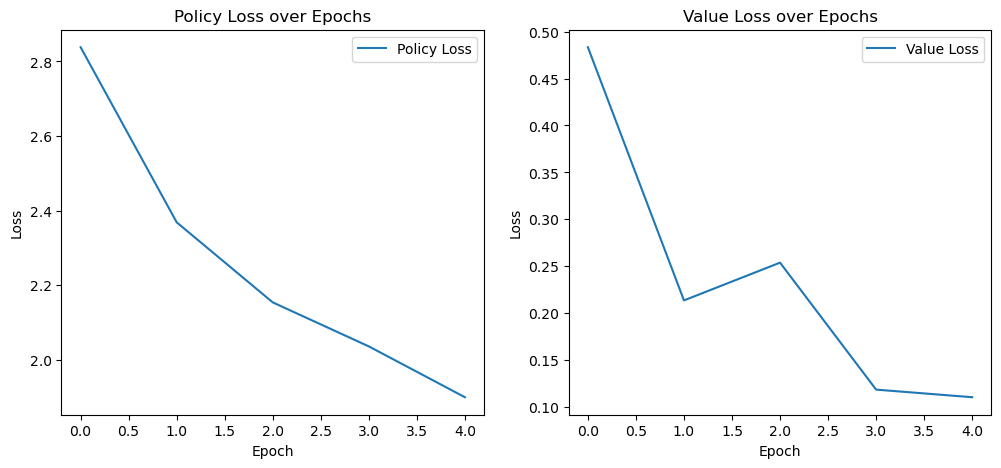

Training completed.

Move 1
[12, 9, 8, 10, 7, 7, 7, 7, 1, 1, 1, 1, 6, 5, 4, 3, 1]
♚ ♞ ♜ ♝ 
♟ ♟ ♟ ♟ 
♙ ♙ ♙ ♙ 
♔ ♕ ♗ ♘ 
White to Move
Number of visits for each child of the parent node (position: [12, 9, 8, 10, 7, 7, 7, 7, 1, 1, 1, 1, 6, 5, 4, 3, 1]):
Move from 8 to 5 (Promotion: 0) -> Visits (N): 768 -> Total Action Value (W): 768
Move from 9 to 4 (Promotion: 0) -> Visits (N): 0 -> Total Action Value (W): 0
Move from 9 to 6 (Promotion: 0) -> Visits (N): 32 -> Total Action Value (W): 2.5644481778144836
Move from 10 to 5 (Promotion: 0) -> Visits (N): 0 -> Total Action Value (W): 0
Move from 10 to 7 (Promotion: 0) -> Visits (N): 0 -> Total Action Value (W): 0
Move from 11 to 6 (Promotion: 0) -> Visits (N): 0 -> Total Action Value (W): 0
Move from 15 to 6 (Promotion: 0) -> Visits (N): 0 -> Total Action Value (W): 0
Saving the first move: (8, 5, 0)
Player 1 chooses action: (8, 5, 0)
Game over: checkmate
White wins!
[12, 9, 8, 10, 7, 1, 7, 7, 0, 1, 1, 1, 6, 5, 4, 3, 2]
♚ ♞ ♜ ♝ 
♟ ♙ ♟ ♟ 
  ♙ ♙

((8, 5, 0), 1)

In [52]:
test_pos = [12, 9, 8, 10, 7, 7, 7, 7, 1, 1, 1, 1, 6, 5, 4, 3, 1]
train_path = 'best_alpha_zero_net.pth'
display_position(test_pos)

sample_training(test_pos) # Training the test position
#display_position(best_move_calculator(test_pos, train_path)) # getting the best postion
play_game_from_position(test_pos, train_path)